# Pipeline de transformación y exploración gráfica de los datos.

El propósito de este notebook es crear un conjunto de funciones que nos ayuden a preparar y transformar los datos para el resto de las operaciones. También se muestran aquí las gráficas del slide deck del EDA. 


Nota: Las gráficas incluyen cifras a partir de 2014 porque solo había 25 registros de 2013 y consideramos que era mejor mostrar promedios en la octava gráfica en los Facet Grids.

In [1]:
#%load_ext pycodestyle_magic
#%pycodestyle_on

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime
import numpy as np
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mtick

In [2]:
#define categorical, numerical and date columns
CAT_COLS = ["dia_semana", "codigo_cierre", "año_cierre", "mes_cierre", "mes", "delegacion_inicio", 
            "incidente_c4", "clas_con_f_alarma", "tipo_entrada", "delegacion_cierre", "hora_creacion",
           "hora_cierre"]

DATE_COLS = ["fecha_creacion", "fecha_cierre"]

NUM_COLS = ["latitud", "longitud"]

In [3]:
#esto irá en el script ingestion .py
def ingest_file(file_name):
    """
    Function to retrieve and return the accidents dataset.
    Parameters:
    -----------
    file_name: str
               Path to the file.
    Returns:
    --------
    df: pandas dataframe
    """
    df = pd.read_csv(file_name)
    return df


def drop_cols(df):
    """
    Function to drop unnnecesary columns in the dataset.
    """
    df.drop(columns = ['folio', 'geopoint', 'mes', 'mes_cierre', 'hora_cierre', 'año_cierre'], inplace = True)
    return df



def fill_na(df):
    """
    Function to fill null values in a dataframe.
    """
    #aquí podemos ir agregando más cosas cuando descubramos 
    #cómo imputar valores faltantes para latitud y longitud
    df.fillna({
        'delegacion_inicio': 'No Disponible',
        'delegacion_cierre': 'No Disponible'
              }, inplace = True)
    return df


def categoric_transformation(col,df):
    df[col] = df[col].astype("category")
    return df 

def create_categorical(cols, df):
    """
    Function to transform and prepare the categorical features in the dataset.
    """
    #transform to appropriate data type
    for col in cols: 
        df = categoric_transformation(col, df)
     
    return df


def date_transformation(col,df):
    """
    Function to prepare and transform date-type columns. 
    """
    df[col] = pd.to_datetime(df[col])
    return df

def create_date_cols(cols, df):
    for col in cols:
        df = date_transformation(col, df)
    return df 



def generate_label(df):
    """
    Function to create a new column indicating whether there was
    a false alarm or not. 
    Parameters:
    -----------
    df: pandas dataframe
    
    Returns:
    --------
    df: pandas dataframe
    """
    #transformamos la columna para solo quedarnos con la letra del código
    df["codigo_cierre"] = df["codigo_cierre"].apply(lambda x: x[1])
    df['label'] = np.where(
        (df.codigo_cierre == 'F') | (df.codigo_cierre == 'N'), 1, 0)
    return df 


def clean_hora_creacion(df):
    """
    Function to transform hours with incorrect format to timedelta format. 
    """
    horas_raw = df.hora_creacion.values.tolist()
    horas_clean = [datetime.timedelta(days=float(e)) if e.startswith("0.") else e for e in horas_raw]
    df["hora_creacion"] = horas_clean
    return df 


def create_simple_hour(df):
    """
    Function to extract the hour from the column "hora_creacion"
    Parameters:
    -----------
    df: pandas dataframe
    
    Returns:
    ---------
    df: pandas dataframe with a new column indicating the hour. 
    """
    #la función se podria adaptar para devolver minuto o segundo pero no lo considero necesario
    pattern = '\d+' #encuentra uno o más dígitos
    horas_raw = df.hora_creacion.astype(str).values #son así: '22:35:04', '22:50:49', '09:40:11'
    n = len(horas_raw)
    horas_clean = [0]*n #es más rápido reasignar valores que hacer .append()
    for i in range(n):
        hora_raw = horas_raw[i]
        hora_clean = re.match(pattern, hora_raw)[0] #solo queremos la hora, esto devuelve un objeto
        horas_clean[i] = hora_clean
    
    df["hora_simple"] = horas_clean
    return df 


def add_date_columns(df):
    """
    Esta función es muy importante puesto que nos ayudará a crear el mes, día y año de creación
    del registro. De esta manera podemos prescindir de las fechas de cierre, que no tendríamos en tiempo
    real en un modelo. 
    Parameters:
    -----------
    df: pandas dataframe
    
    Returns:
    ---------
    df: pandas dataframe with 4 new columns
    """
    mapping_meses = {1: "Enero", 2: "Febrero", 3: "Marzo", 4: "Abril", 5: "Mayo",
                       6: "Junio", 7: "Julio", 8: "Agosto", 9: "Septiembre", 10: "Octubre",
                       11: "Noviembre", 12: "Diciembre"}
    
    
    df["año_creacion"] = df.fecha_creacion.dt.year
    df["mes_creacion"] = df.fecha_creacion.dt.month
    df["dia_creacion"] = df.fecha_creacion.dt.day
    df["mes_creacion_str"] = df.mes_creacion.map(mapping_meses)
    df["año_creacion"] = df["año_creacion"].astype(str)
    return df 


def create_time_blocks(df):
    """
    Function to group the hour of the day into 3-hour blocks.
    Parameters:
    -----------
    df: pandas dataframe
    
    Returns:
    ---------
    df: pandas dataframe with a new column indicating the time-block.
    """
    horas_int = set(df.hora_simple.astype(int).values) #estaba como categórico
    f = lambda x: 12 if x == 0 else x
    mapping_hours = {}
    for hora in horas_int:
        grupo = (hora // 3) * 3
        if grupo < 12: 
            nombre_grupo = str(f(grupo)) + "-" + str(grupo + 2) + " a.m."
        else:
            hora_tarde = grupo % 12
            nombre_grupo = str(f(hora_tarde)) + "-" + str(hora_tarde + 2) + " p.m."
        mapping_hours[hora] = nombre_grupo
    
    df["espacio_del_dia"] = df["hora_simple"].astype(int).map(mapping_hours)
    return df
    

    

    
def basic_preprocessing(path):
    """
    Function to summarize all the preprocessing done to the data.
    Parameters:
    -----------
    path: str
          Path to your file
    
    Returns:
    ---------
    df: pandas dataframe
    """
    df = ingest_file(path) 
    df = generate_label(df)
    df = fill_na(df) 
    df = clean_hora_creacion(df)
    df = create_categorical(CAT_COLS, df) #transform to appropriate data types
    df = create_date_cols(DATE_COLS, df)
    df = add_date_columns(df)
    df = create_simple_hour(df)
    df = create_time_blocks(df)
    df = drop_cols(df)
    
    return df


In [4]:
data = basic_preprocessing('incidentes-viales-c5.csv')

In [5]:
data.head()

,fecha_creacion,hora_creacion,dia_semana,codigo_cierre,fecha_cierre,delegacion_inicio,incidente_c4,latitud,longitud,clas_con_f_alarma,tipo_entrada,delegacion_cierre,label,año_creacion,mes_creacion,dia_creacion,mes_creacion_str,hora_simple,espacio_del_dia
0,2016-01-23,22:35:04,Sábado,A,2016-01-24,VENUSTIANO CARRANZA,accidente-choque sin lesionados,19.422113,-99.084643,EMERGENCIA,BOTÓN DE AUXILIO,VENUSTIANO CARRANZA,0,2016,1,23,Enero,22,9-11 p.m.
1,2016-01-23,22:50:49,Sábado,A,2016-01-24,CUAJIMALPA,accidente-choque con lesionados,19.358320,-99.297641,URGENCIAS MEDICAS,BOTÓN DE AUXILIO,CUAJIMALPA,0,2016,1,23,Enero,22,9-11 p.m.
2,2016-01-24,09:40:11,Domingo,N,2016-01-24,TLALPAN,accidente-choque sin lesionados,19.217070,-99.219070,EMERGENCIA,LLAMADA DEL 066,TLALPAN,1,2016,1,24,Enero,09,9-11 a.m.
3,2016-01-24,22:40:57,Domingo,N,2016-01-24,MAGDALENA CONTRERAS,accidente-choque sin lesionados,19.320580,-99.241010,EMERGENCIA,LLAMADA DEL 066,MAGDALENA CONTRERAS,1,2016,1,24,Enero,22,9-11 p.m.
4,2016-01-24,04:25:15,Domingo,A,2016-01-24,MIGUEL HIDALGO,accidente-choque sin lesionados,19.452900,-99.215870,EMERGENCIA,LLAMADA DEL 066,MIGUEL HIDALGO,0,2016,1,24,Enero,04,3-5 a.m.


In [6]:
data["label_pos"] = np.where(data.label == 1, 0, 1)
data["año_creacion"] = data["año_creacion"].astype('category')
data["mes_creacion_str"] = data["mes_creacion_str"].astype('category')

In [7]:
colors=["#0C264E", "#c12929"] #fancy shit
#F4B26A

## Proporción de llamadas falsas por delegación de 2014-2020.

Es natural preguntarse cuál es la proporción de llamadas falsas o negativas (las que tienen label == 1) para cada delegación en cada año.

In [8]:
#el promedio de una columna de 0's y 1's es la proporción de 1's en esa columna. 
prop = data.groupby(["delegacion_inicio", "año_creacion"], as_index = False)
prop = prop.mean()[["delegacion_inicio", "año_creacion", "label"]]
prop = prop[prop.delegacion_inicio != "No Disponible"]
prop["delegacion_inicio"] = [e.lower().title() for e in prop.delegacion_inicio.values]
prop.head()

,delegacion_inicio,año_creacion,label
0,Alvaro Obregon,2013,0.500000
1,Alvaro Obregon,2014,0.191288
2,Alvaro Obregon,2015,0.212632
3,Alvaro Obregon,2016,0.250600
4,Alvaro Obregon,2017,0.230548


In [9]:
#solo son 7 años y tengo 8 campos
#tengo que agregar un campo adicional para llenar el facet grid; agreguemos el promedio
promedio = prop.groupby(['delegacion_inicio'], as_index=False).agg({'label': 'mean'})
promedio = promedio.sort_values(by=["label"], ascending=False)
promedio = promedio.iloc[:5,]

In [10]:
group0 = prop[prop["año_creacion"] == str(2014)].sort_values(by = "label", ascending = False).iloc[:5,:]
group0.delegacion_inicio

33              Cuajimalpa
73     Magdalena Contreras
105                Tlahuac
113                Tlalpan
57               Iztacalco
Name: delegacion_inicio, dtype: object

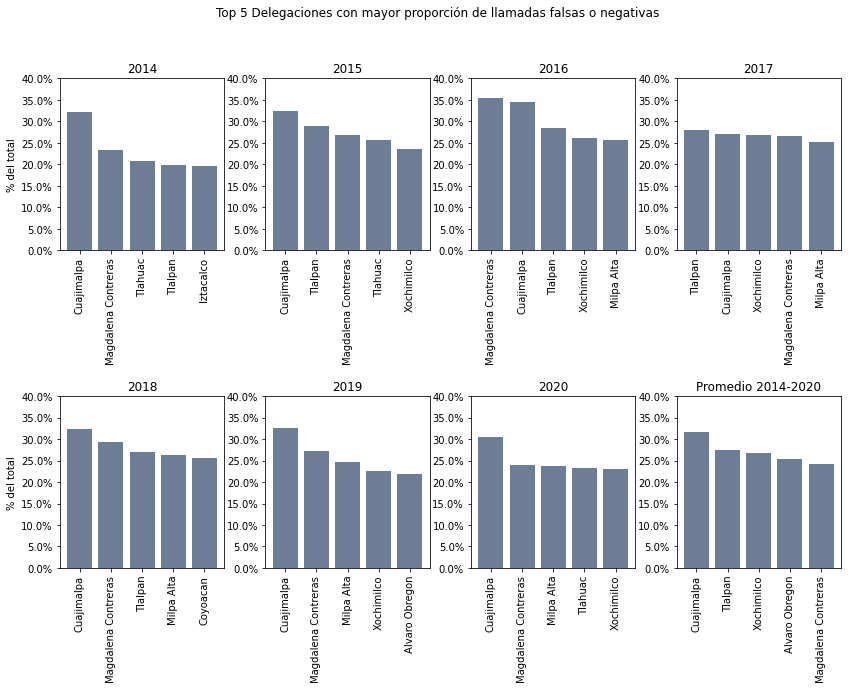

<Figure size 7200x4800 with 0 Axes>

In [11]:
#inicializar gráfica masiva 
fig, axs = plt.subplots(2,4, figsize = (14,10))
plt.subplots_adjust(wspace = .25, hspace = .85, bottom = .20)
fig.suptitle('Top 5 Delegaciones con mayor proporción de llamadas falsas o negativas')
plt.figure(dpi=1200)

#llenar el facet grid 
for i in range(8):
    año = 2014 + i #2014, 2015,..., 2020
    row = i // 4  
    col = i % 4
    #filtramos solo por año 
    grouping = prop[prop["año_creacion"] == str(año)].sort_values(by = "label", ascending = False).iloc[:5,:]
    delegaciones = [e.lower().title() for e in grouping.delegacion_inicio.values][:5]

    axs[row,col].bar(grouping.delegacion_inicio, grouping.label, align='center', 
                     alpha=0.6, color=colors[0])
    axs[row,col].set_title(f"{str(año)}")
    axs[row,col].set_ylim([0,.40])
    axs[row,col].set_xticks(range(5))
    axs[row,col].set_xticklabels(delegaciones, rotation = 90)
    axs[row,col].yaxis.set_major_formatter(mtick.PercentFormatter(1))
    if i == 0 or i == 4: 
        axs[row,col].set(ylabel = "% del total")
    #campo del promedio se llena de formam distinta
    if row == 1 and col == 3: 
        axs[row,col].bar(promedio.delegacion_inicio, promedio.label, align = "center", 
                        alpha=0.6, color=colors[0])
        delegaciones = [e for e in promedio.delegacion_inicio.values]
        axs[row,col].set_title("Promedio 2014-2020")
        axs[row,col].set_ylim([0,.40])
        axs[row,col].set_xticks(range(5))
        axs[row,col].set_xticklabels(delegaciones, rotation = 90)
        axs[row,col].yaxis.set_major_formatter(mtick.PercentFormatter(1))

        

plt.show();
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
#fig.savefig('top5_deleg.png', edgecolor='none')
#TO DO: poner solo las top 5 delegaciones no? 

In [12]:
#poner en el slide deck 

Podemos ver que prácticamente son las mismas colonias las que predominan en la lista. 

# Proporción de llamadas falsas o negativas por año. 

In [13]:
#Este será el facet grid más sencillo, antes del infierno de código a continuación. 

In [14]:
prop_label = data.groupby(["año_creacion"], as_index = False).agg({'label': 'mean', 'label_pos': 'mean'})
prop_label[prop_label.año_creacion == '2013'].T.reset_index().iloc[1:,].rename(columns={0: "proportions"})

,index,proportions
1,label,0.16
2,label_pos,0.84


In [15]:
promedio_label = prop_label[["label", "label_pos"]].mean()
promedio_label

label        0.197573
label_pos    0.802427
dtype: float64

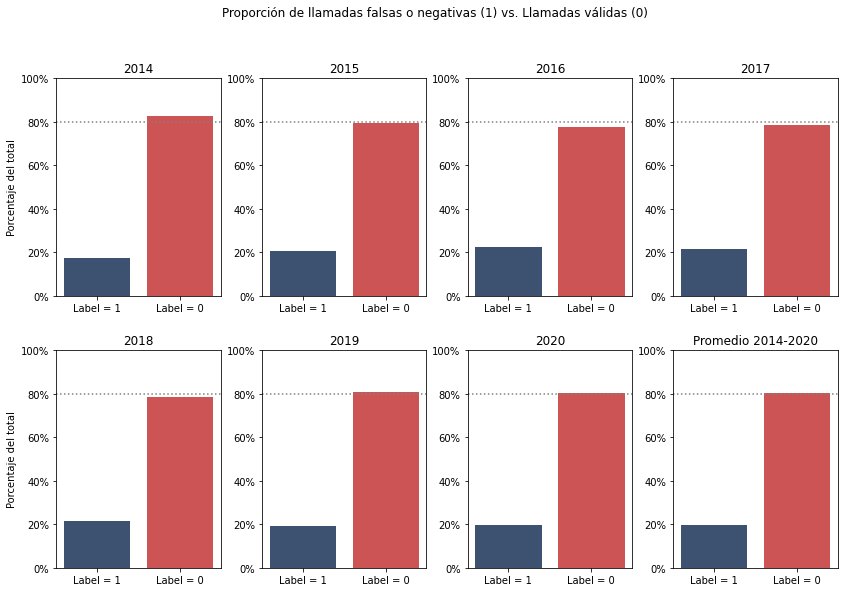

<Figure size 7200x4800 with 0 Axes>

In [16]:
#inicializar gráfica masiva 
fig, axs = plt.subplots(2,4, figsize = (14,10))
plt.subplots_adjust(wspace = .25, hspace = .25, bottom = .20)
plt.figure(dpi=1200)
fig.suptitle('Proporción de llamadas falsas o negativas (1) vs. Llamadas válidas (0)')

#llenar el facet grid 
for i in range(7):
    año = 2014 + i #2014, 2015,..., 2020
    row = i // 4  
    col = i % 4
    #filtramos solo por año 
    grouping = prop_label[prop_label["año_creacion"] == str(año)].T.reset_index().iloc[1:,]
    #print(grouping)
    etiquetas = ["Label = 1", "Label = 0"]
    #OXFORD BLUE, mother fuckers: "#0C264E"
    axs[row,col].bar(grouping.index, grouping.iloc[:,1], align='center', 
                     alpha=.8, color=["#0C264E", "#c12929"])
    axs[row,col].set_title(f"{str(año)}")
    axs[row,col].set_ylim([0,1])
    axs[row,col].set_xticks([1,2])
    axs[row,col].set_xticklabels(etiquetas, rotation = 0)
    axs[row,col].axhline(.80, linestyle='dotted', color='gray')
    axs[row,col].yaxis.set_major_formatter(mtick.PercentFormatter(1))
    if i == 0 or i == 4: 
        axs[row,col].set(ylabel = "Porcentaje del total")
    #campo del promedio se llena de forma distinta

axs[1,3].bar(etiquetas, promedio_label.values, align = "center", alpha=0.8, color=["#0C264E", "#c12929"])
axs[1,3].set_title("Promedio 2014-2020")
axs[1,3].set_ylim([0,1])
axs[1,3].set_xticks(range(2))
axs[1,3].set_xticklabels(etiquetas, rotation = 0)
axs[1,3].axhline(.80, linestyle='dotted', color='gray')
axs[1,3].yaxis.set_major_formatter(mtick.PercentFormatter(1))
        
#plt.sca(axs[0,3])
#plt.xticks(list(range(16)), ["str(e)" for e in range(16)], rotation=90)
#plt.savefig("top_5_proporcion_v0.png")
plt.show();
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
#fig.savefig('prop_label2.png', edgecolor='none')
#TO DO: poner solo las top 5 delegaciones no? 

# Porcentaje de llamadas negativas por mes. 

In [17]:
prop_mensual = data.copy()
prop_mensual = prop_mensual[['año_creacion', 'mes_creacion_str', 'label', 'label_pos']]
prop_mensual = prop_mensual.groupby(["año_creacion", "mes_creacion_str"], as_index = False, dropna=False)
prop_mensual = prop_mensual.mean()[["año_creacion", "mes_creacion_str", "label", "label_pos"]]
prop_mensual = prop_mensual[prop_mensual.año_creacion != "2013"]
prop_mensual.head()

,año_creacion,mes_creacion_str,label,label_pos
12,2014,Abril,0.165853,0.834147
13,2014,Agosto,0.174530,0.825470
14,2014,Diciembre,0.189993,0.810007
15,2014,Enero,0.156179,0.843821
16,2014,Febrero,0.157672,0.842328


In [18]:
mapping_meses_2 = {"Enero": 1, "Febrero": 2, "Marzo":3, "Abril": 4, "Mayo":5, "Junio":6,
                  "Julio": 7, "Agosto": 8, "Septiembre": 9, "Octubre": 10, 
                  "Noviembre": 11, "Diciembre": 12}

prop_mensual["id"] = prop_mensual.mes_creacion_str.map(mapping_meses_2).astype(int)
prop_mensual.sort_values(by=['id'], inplace = True)
prop_mensual.head()

,año_creacion,mes_creacion_str,label,label_pos,id
87,2020,Enero,0.209871,0.790129,1
15,2014,Enero,0.156179,0.843821,1
27,2015,Enero,0.199784,0.800216,1
39,2016,Enero,0.224296,0.775704,1
51,2017,Enero,0.217405,0.782595,1


In [20]:
#ahora el promedio de todos los años
prop_mensual_total = prop_mensual.groupby(["mes_creacion_str"], as_index = False).agg({
    'label': 'mean',
    'label_pos': 'mean'
}) 
prop_mensual_total["id"] = prop_mensual_total.mes_creacion_str.map(mapping_meses_2).astype(int)
prop_mensual_total = prop_mensual_total.sort_values(by=['id'])
prop_mensual_total.head()

,mes_creacion_str,label,label_pos,id
3,Enero,0.202534,0.797466,1
4,Febrero,0.199492,0.800508,2
7,Marzo,0.198589,0.801411,3
0,Abril,0.197995,0.802005,4
8,Mayo,0.196634,0.803366,5


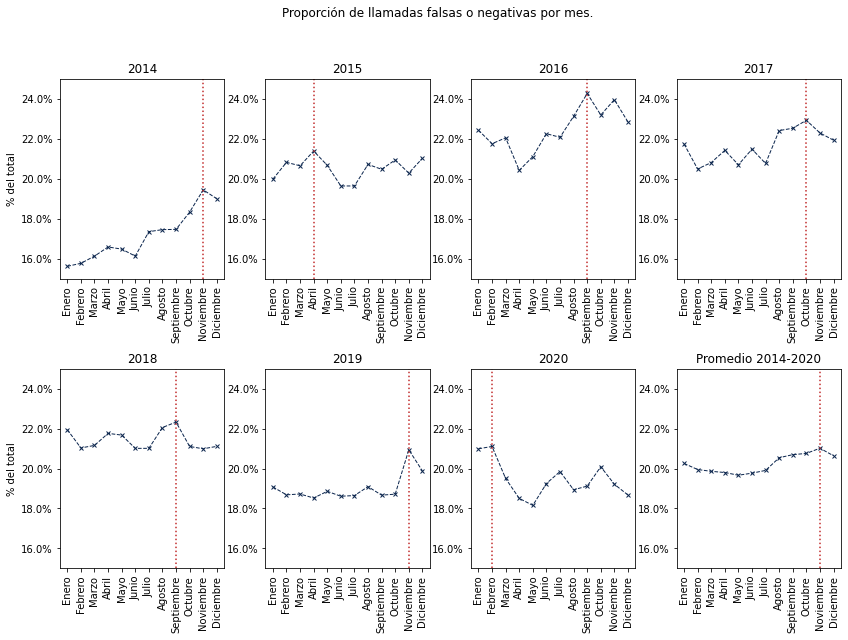

<Figure size 7200x4800 with 0 Axes>

In [21]:
#estas gráficas me explotan la cabeza
#inicializar gráfica masiva
fig, axs = plt.subplots(2,4, figsize = (14,10))
plt.subplots_adjust(wspace = .25, hspace = .45, bottom = .20)
plt.figure(dpi=1200)
fig.suptitle('Proporción de llamadas falsas o negativas por mes.')

#llenar el facet grid 
for i in range(7):
    año = 2014 + i #2014, 2015,..., 2020
    row = i // 4  
    col = i % 4
    #filtramos solo por año 
    grouping = prop_mensual[prop_mensual["año_creacion"] == str(año)]
    meses = [e.lower().title() for e in grouping.mes_creacion_str.values]
    x = np.array([e for e in range(12)]).reshape(12,)
    y = np.array(grouping.label.values).reshape(12,)
    axs[row,col].plot(x, y, marker = "x", linestyle='--', 
                      linewidth=1, markersize = 4, color = "#0C264E") #label = "label = 1")
   # axs[row,col].plot(x, grouping.label_pos.values, marker = "^", linestyle='--', linewidth=1, 
    #                  markersize = 4, label = "label = 0")
    axs[row,col].set_title(f"{str(año)}")
    axs[row,col].set_ylim([.15, .25])
    axs[row,col].set_xticks(range(12))
    axs[row,col].set_xticklabels(meses, rotation = 90)
    maximo = grouping[grouping.label == grouping.label.max()].id.values
    axs[row,col].axvline(maximo-1, linestyle='dotted', color="#c12929")
    axs[row,col].yaxis.set_major_formatter(mtick.PercentFormatter(1))
    if i == 0 or i == 4: 
        axs[row,col].set(ylabel = "% del total")
        #axs[row,col].legend(loc = "upper left")
    #campo del promedio se llena de forma distinta
    if i == 6: 
        x = np.array([e for e in range(12)]).reshape(12,)
        axs[1,3].plot(x, prop_mensual_total.label.values, linestyle='--', marker = "x", 
                      color = "#0C264E", linewidth=1, markersize = 4)
      #  axs[1,3].plot(x, prom_dia.label_pos.values, linestyle="--", marker="^", linewidth=1, markersize =4)
        axs[1,3].set_title("Promedio 2014-2020")
        axs[1,3].set_ylim([.15, .25])
        axs[1,3].set_xticks(range(12))
        axs[1,3].set_xticklabels(meses, rotation = 90)
        axs[1,3].axvline(10, linestyle='dotted', color="#c12929")
        axs[1,3].yaxis.set_major_formatter(mtick.PercentFormatter(1))
#plt.sca(axs[0,3])
#plt.xticks(list(range(16)), ["str(e)" for e in range(16)], rotation=90)
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
#fig.savefig('analisis_mensual_OXFORD.png', edgecolor='none')
plt.show();

## Llamadas falsas o negativas por día de la semana.

También es natural preguntarse qué días de la semana tuvieron más llamadas falsas. También podemos dividir por año el facetgrid. 

In [22]:
mapping_dias = {"Lunes": 1, "Martes": 2, "Miércoles": 3,
                "Jueves": 4, "Viernes": 5, "Sábado": 6, "Domingo": 7}

In [23]:
data.dtypes

fecha_creacion       datetime64[ns]
hora_creacion              category
dia_semana                 category
codigo_cierre              category
fecha_cierre         datetime64[ns]
delegacion_inicio          category
incidente_c4               category
latitud                     float64
longitud                    float64
clas_con_f_alarma          category
tipo_entrada               category
delegacion_cierre          category
label                         int64
año_creacion               category
mes_creacion                  int64
dia_creacion                  int64
mes_creacion_str           category
hora_simple                  object
espacio_del_dia              object
label_pos                     int64
dtype: object

In [24]:
dia_semana = data.groupby(["dia_semana", "año_creacion"], as_index = False)
dia_semana = dia_semana.mean()[["año_creacion", "dia_semana", "label", "label_pos"]]
dia_semana["id"] = dia_semana.dia_semana.map(mapping_dias)
dia_semana["id"] = dia_semana.id.astype(int)
dia_semana = dia_semana.sort_values(by=['id'], ascending = True)
#dia_semana[dia_semana.año_creacion == '2015']

In [25]:
prom_dia = dia_semana.groupby(["dia_semana"], as_index = False).agg({'label': 'mean', "label_pos": "mean"})
prom_dia["id"] = prom_dia.dia_semana.map(mapping_dias)
prom_dia["id"] = prom_dia.id.astype(int)
prom_dia = prom_dia.sort_values(by=['id'], ascending = True)
prom_dia

,dia_semana,label,label_pos,id
2,Lunes,0.200204,0.799796,1
3,Martes,0.199331,0.800669,2
4,Miércoles,0.206857,0.793143,3
1,Jueves,0.206538,0.793462,4
6,Viernes,0.217260,0.782740,5
5,Sábado,0.193260,0.806740,6
0,Domingo,0.188855,0.811145,7


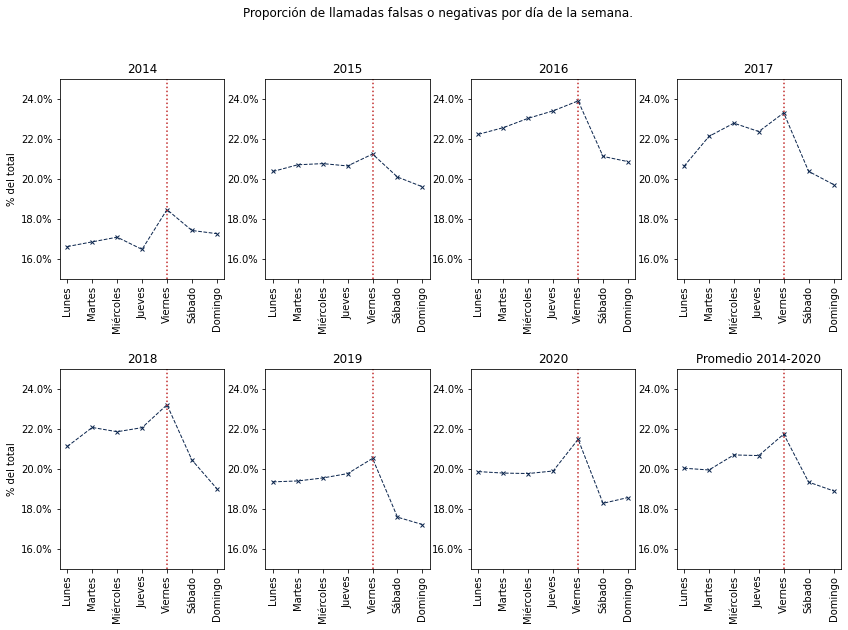

<Figure size 7200x4800 with 0 Axes>

In [26]:
#inicializar gráfica masiva
fig, axs = plt.subplots(2,4, figsize = (14,10))
plt.subplots_adjust(wspace = .25, hspace = .45, bottom = .20)
plt.figure(dpi=1200)
fig.suptitle('Proporción de llamadas falsas o negativas por día de la semana.')

#llenar el facet grid 
for i in range(7):
    año = 2014 + i #2014, 2015,..., 2020
    row = i // 4  
    col = i % 4
    #filtramos solo por año 
    grouping = dia_semana[dia_semana["año_creacion"] == str(año)]
    dias = [e.lower().title() for e in grouping.dia_semana.values]
    x = np.array([e for e in range(7)]).reshape(7,)
    y = np.array(grouping.label.values).reshape(7,)
    axs[row,col].plot(x, y, marker = "x", linestyle='--', 
                      linewidth=1, markersize = 4, color = "#0C264E") #label = "label = 1")
   # axs[row,col].plot(x, grouping.label_pos.values, marker = "^", linestyle='--', linewidth=1, 
    #                  markersize = 4, label = "label = 0")
    axs[row,col].set_title(f"{str(año)}")
    axs[row,col].set_ylim([.15, .25])
    axs[row,col].set_xticks(range(7))
    axs[row,col].set_xticklabels(dias, rotation = 90)
    axs[row,col].axvline(4, linestyle='dotted', color="#c12929")
    axs[row,col].yaxis.set_major_formatter(mtick.PercentFormatter(1))
    if i == 0 or i == 4: 
        axs[row,col].set(ylabel = "% del total")
        #axs[row,col].legend(loc = "upper left")
    #campo del promedio se llena de forma distinta
    if i == 6: 
        x = [e for e in range(7)]
        axs[1,3].plot(x, prom_dia.label.values, linestyle='--', marker = "x", 
                      color = "#0C264E", linewidth=1, markersize = 4)
      #  axs[1,3].plot(x, prom_dia.label_pos.values, linestyle="--", marker="^", linewidth=1, markersize =4)
        dias = [e for e in prom_dia.dia_semana.values]
        axs[1,3].set_title("Promedio 2014-2020")
        axs[1,3].set_ylim([.15, .25])
        axs[1,3].set_xticks(range(7))
        axs[1,3].set_xticklabels(dias, rotation = 90)
        axs[1,3].axvline(4, linestyle='dotted', color="#c12929")
        axs[1,3].yaxis.set_major_formatter(mtick.PercentFormatter(1))
#plt.sca(axs[0,3])
#plt.xticks(list(range(16)), ["str(e)" for e in range(16)], rotation=90)
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
#fig.savefig('dia_semana_OXFORD.png', edgecolor='none')
plt.show();

In [27]:
#incluir esta en el slide deck 
#estaría lindo una línea vertical en el viernes

# ¿Y en qué horario ocurren estas llamadas?

Podemos ver que indudablemente el viernes es el día en donde más llamadas falsas hay. Una pregunta que surge naturalmente al entender el día donde hay más llamadas falsas es, ¿en qué horario ocurren estas llamadas? Para esto podemos crear una variable adicional que indique el bloque de tiempo (en grupos de 3 horas) donde ocurren estas llamadas. 

In [28]:
#la variable se llama espacio_del_dia, y se ve así:
data.iloc[:5,12:]

,label,año_creacion,mes_creacion,dia_creacion,mes_creacion_str,hora_simple,espacio_del_dia,label_pos
0,0,2016,1,23,Enero,22,9-11 p.m.,1
1,0,2016,1,23,Enero,22,9-11 p.m.,1
2,1,2016,1,24,Enero,09,9-11 a.m.,0
3,1,2016,1,24,Enero,22,9-11 p.m.,0
4,0,2016,1,24,Enero,04,3-5 a.m.,1


In [29]:
#también conviene usar el método map para crear una variable que nos ayude a ordenarlas 
mapping_espacio = {"12-2 a.m.": 1, "3-5 a.m.": 2, "6-8 a.m.": 3, "9-11 a.m.": 4,
                  "12-2 p.m.": 5, "3-5 p.m.": 6, "6-8 p.m.": 7, "9-11 p.m.": 8}

In [30]:
horario_frecuente = data.groupby(["espacio_del_dia", "dia_semana"], as_index = False)
horario_frecuente = horario_frecuente.sum()[["espacio_del_dia", "dia_semana", "label", "label_pos"]]
horario_frecuente["id"] = horario_frecuente["espacio_del_dia"].map(mapping_espacio).astype(int)
horario_frecuente = horario_frecuente.sort_values(by=["id"])
horario_frecuente.head()

,espacio_del_dia,dia_semana,label,label_pos,id
0,12-2 a.m.,Domingo,3888,17737,1
1,12-2 a.m.,Jueves,1503,8507,1
2,12-2 a.m.,Lunes,1375,7766,1
3,12-2 a.m.,Martes,984,6203,1
4,12-2 a.m.,Miércoles,1284,7733,1


In [31]:
prom_dia = horario_frecuente.groupby(["espacio_del_dia"], as_index = False).agg({'label': 'sum', 
                                                                                 'label_pos': 'sum'})
#prom_dia = prom_dia.agg({'label': 'mean'})
prom_dia["id"] = prom_dia["espacio_del_dia"].map(mapping_espacio).astype(int)
prom_dia = prom_dia.sort_values(by=["id"])
prom_dia

,espacio_del_dia,label,label_pos,id
0,12-2 a.m.,15412,79349,1
2,3-5 a.m.,8962,45983,2
4,6-8 a.m.,23052,99115,3
6,9-11 a.m.,33072,136024,4
1,12-2 p.m.,42776,160661,5
3,3-5 p.m.,51777,195405,6
5,6-8 p.m.,61453,210415,7
7,9-11 p.m.,45799,173883,8


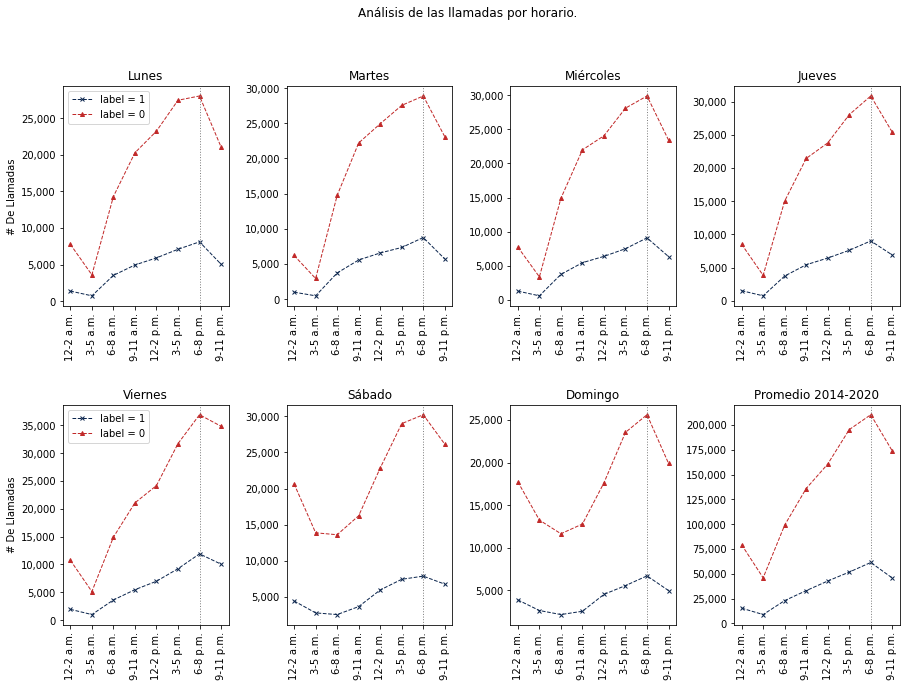

<Figure size 7200x4800 with 0 Axes>

In [32]:
#inicializar gráfica masiva
fig, axs = plt.subplots(2,4, figsize = (15,11))
plt.subplots_adjust(wspace = .35, hspace = .45, bottom = .20)
plt.figure(dpi=1200)
fig.suptitle('Análisis de las llamadas por horario.')


#llenar el facet grid 
dias = ["Lunes", "Martes", "Miércoles", "Jueves", "Viernes", "Sábado", "Domingo"]
for i in range(7):
    dia = dias[i] 
    row = i // 4  
    col = i % 4
    #filtramos solo por dia de la semana  
    grouping = horario_frecuente[horario_frecuente["dia_semana"] == dia]
    bloques_horarios = grouping["espacio_del_dia"].values.tolist()
    x = range(8)
    axs[row,col].plot(x, grouping.label, marker = "x", linestyle='--', linewidth=1, markersize = 4,
                     label = "label = 1", color = colors[0] )
    axs[row,col].plot(x, grouping.label_pos, marker = "^", linestyle='--', linewidth=1, markersize = 4,
                     label = "label = 0", color = colors[1])
    axs[row,col].set_title(dia)
    #axs[row,col].set_ylim([0, 14_000])
    axs[row,col].set_xticks(range(8))
    axs[row,col].set_xticklabels(bloques_horarios, rotation = 90)
    axs[row,col].axvline(6, linestyle='dotted', color='gray', linewidth=1)
    axs[row,col].yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
    #axs[row,col].legend(loc="upper left")
    if i == 0 or i == 4: 
        axs[row,col].set(ylabel = "# De Llamadas")
        axs[row,col].legend(loc="upper left")

#campo del promedio se llena de forma distinta
axs[1,3].plot(x, prom_dia.label, marker = "x", linestyle='--', linewidth=1, 
              markersize = 4, label = "label = 1", color = colors[0])
axs[1,3].plot(x, prom_dia.label_pos, marker = "^", linestyle='--', 
              linewidth=1, markersize = 4, label = "label = 0", color = colors[1])
bloques_horarios = prom_dia.espacio_del_dia.values.tolist()
axs[1,3].set_title("Promedio 2014-2020")
#axs[1,3].set_ylim([5000,65_000])
axs[1,3].set_xticks(range(8))
axs[1,3].set_xticklabels(bloques_horarios, rotation = 90)
axs[1,3].axvline(6, linestyle='dotted', color='gray', linewidth=1)
axs[1,3].yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
              
#plt.sca(axs[0,3])
#plt.xticks(list(range(16)), ["str(e)" for e in range(16)], rotation=90)
#plt.legend()
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
#fig.savefig('hora_dia_OXFORD.png', edgecolor='none')
plt.show();

In [33]:
#poner esta en el slide deck 

In [34]:
#también podríamos agregar por año para ver si hay algún patrón desde esa perspectiva
horario_anual = data.groupby(["espacio_del_dia", "año_creacion"], as_index = False)
horario_anual = horario_anual.mean()[["espacio_del_dia", "año_creacion", "label"]]
horario_anual["id"] = horario_anual["espacio_del_dia"].map(mapping_espacio).astype(int)
horario_anual = horario_anual.sort_values(by=["id"])
horario_anual.head()

,espacio_del_dia,año_creacion,label,id
0,12-2 a.m.,2013,NaN,1
1,12-2 a.m.,2014,0.152725,1
2,12-2 a.m.,2015,0.163032,1
3,12-2 a.m.,2016,0.182319,1
4,12-2 a.m.,2017,0.166754,1


In [35]:
horario_anual.dtypes

espacio_del_dia      object
año_creacion       category
label               float64
id                    int64
dtype: object

In [36]:
prom_anual = horario_anual.groupby(["espacio_del_dia"], as_index = False).agg({'label': 'mean'})
prom_anual["id"] = prom_anual["espacio_del_dia"].map(mapping_espacio).astype(int)
prom_anual = prom_anual.sort_values(by=["id"])
prom_anual

,espacio_del_dia,label,id
0,12-2 a.m.,0.162941,1
2,3-5 a.m.,0.162622,2
4,6-8 a.m.,0.187252,3
6,9-11 a.m.,0.194575,4
1,12-2 p.m.,0.182655,5
3,3-5 p.m.,0.208208,6
5,6-8 p.m.,0.259504,7
7,9-11 p.m.,0.195317,8


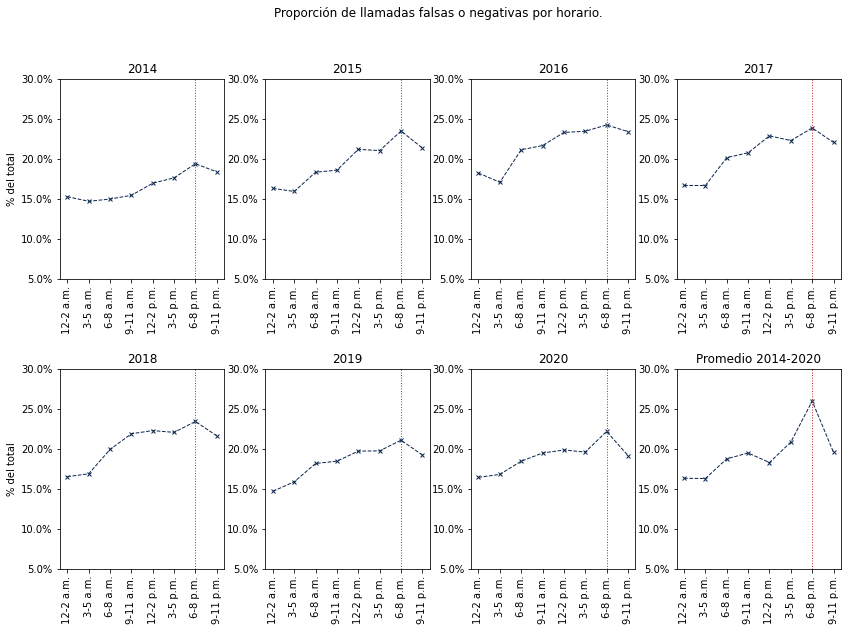

<Figure size 7200x4800 with 0 Axes>

In [37]:
#inicializar gráfica masiva
fig, axs = plt.subplots(2,4, figsize = (14,10))
plt.subplots_adjust(wspace = .25, hspace = .45, bottom = .20)
plt.figure(dpi=1200)
fig.suptitle('Proporción de llamadas falsas o negativas por horario.')

#llenar el facet grid 
for i in range(7):
    año = 2014 + i #2014, 2015,..., 2020
    row = i // 4  
    col = i % 4
    #filtramos solo por año
    #aquí filtra por la variable que va en el facet grid (por la que explotas)
    grouping = horario_anual[horario_anual["año_creacion"] == str(año)] #aquí pon tu agrupamiento
    bloques_horario = grouping.espacio_del_dia.values #las etiquetas del eje x
    x = np.array([e for e in range(8)]).reshape(8,) #si x no es numérico, pon el rango 
    y = np.array(grouping.label.values).reshape(8,) #los valores que van en el eje y (numérico)
    axs[row,col].plot(x, y, marker = "x", linestyle='--', 
                      linewidth=1, markersize = 4, color=colors[0])
    axs[row,col].set_title(f"{str(año)}")
    axs[row,col].set_ylim([.05,.30])
    axs[row,col].set_xticks(range(8))
    axs[row,col].set_xticklabels(bloques_horario, rotation = 90) #aquí van tus etiquetas
    axs[row,col].axvline(6, linestyle='dotted', color=colors[1], linewidth=1)
    axs[row,col].yaxis.set_major_formatter(mtick.PercentFormatter(1))
    if i == 0 or i == 4: 
        axs[row,col].set(ylabel = "% del total")
    #campo del promedio se llena de forma distinta
    if i == 6: 
        x = [e for e in range(8)]
        axs[1,3].plot(x, prom_anual.label.values, linestyle='--', marker = "x", 
                      color=colors[0], linewidth=1, markersize = 4)
        bloques = prom_anual.espacio_del_dia.values #etiquetas del eje x de los promedios
        axs[1,3].set_title("Promedio 2014-2020")
        axs[1,3].set_ylim([.05,.30])
        axs[1,3].set_xticks(range(8))
        axs[1,3].set_xticklabels(bloques, rotation = 90)
        axs[1,3].axvline(6, linestyle='dotted', color=colors[1], linewidth=1)
        axs[1,3].yaxis.set_major_formatter(mtick.PercentFormatter(1))
#plt.sca(axs[0,3])
#plt.xticks(list(range(16)), ["str(e)" for e in range(16)], rotation=90)
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
#fig.savefig('horario_anual_OXFORD.png', edgecolor='none')
plt.show();

In [38]:
#poner esta en el slide deck 

Ver los horarios a gran escala nos permite identificar que en general ocurren más llamadas en la parte final del día, sobre todo de 6 a 8 de la noche.